In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import soundfile as sf
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# ============================
#   ACOUSTIC DECODER NOTEBOOK
# ============================

!pip install librosa soundfile torchinfo einops

import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from einops import rearrange
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Data paths
DATA_ROOT = "/content/drive/MyDrive/EEG_Speech_Dataset"
ACOUSTIC_PATH = f"{DATA_ROOT}/Acoustic"

print("Acoustic files:", os.listdir(ACOUSTIC_PATH))


Mounted at /content/drive
Acoustic files: ['sub-01_features.npy', 'sub-01_spectrogram.npy', 'sub-02_features.npy', 'sub-02_spectrogram.npy', 'sub-03_features.npy', 'sub-03_spectrogram.npy', 'sub-04_features.npy', 'sub-04_spectrogram.npy', 'sub-05_features.npy', 'sub-05_spectrogram.npy', 'sub-06_spectrogram.npy', 'sub-06_features.npy', 'sub-07_features.npy', 'sub-08_spectrogram.npy', 'sub-07_spectrogram.npy', 'sub-08_features.npy', 'sub-09_spectrogram.npy', 'sub-09_features.npy', 'sub-11_spectrogram.npy', 'sub-10_features.npy', 'sub-11_features.npy', 'sub-10_spectrogram.npy', 'sub-12_spectrogram.npy', 'sub-12_features.npy', 'sub-13_features.npy', 'sub-13_spectrogram.npy', 'sub-14_features.npy', 'sub-14_spectrogram.npy', 'sub-15_features.npy', 'sub-15_spectrogram.npy']


Load One Subject & Inspect Shapes

In [ ]:
# Choose which subject to inspect
sub = "15"   # you can change "15" to any subject number

eeg_path = f"{ACOUSTIC_PATH}/sub-{sub}_features.npy"
mel_path = f"{ACOUSTIC_PATH}/sub-{sub}_spectrogram.npy"

# Load files
EEG = np.load(eeg_path)
MEL = np.load(mel_path)

print("EEG raw shape      :", EEG.shape)   # (T_eeg, 1143)
print("Mel spectrogram    :", MEL.shape)   # (T_mel, 23)

# Extract numbers
T_eeg = EEG.shape[0]
flat_dim = EEG.shape[1]
T_mel = MEL.shape[0]
mel_bins = MEL.shape[1]

print("\nExtracted:")
print("T_eeg =", T_eeg)
print("Flattened EEG dim =", flat_dim)
print("T_mel =", T_mel)
print("Mel bins =", mel_bins)


EEG raw shape      : (30004, 585)
Mel spectrogram    : (30004, 23)

Extracted:
T_eeg = 30004
Flattened EEG dim = 585
T_mel = 30004
Mel bins = 23


Reshape EEG & Compute Channel Count

In [ ]:
# EEG flatten dimension = 9 timeframes × C channels → C = flat_dim / 9
C = flat_dim // 9

EEG_reshaped = EEG.reshape(T_eeg, 9, C)
print("EEG reshaped shape:", EEG_reshaped.shape)

print("\nNumber of channels =", C)
print("Number of lag frames =", 9)


EEG reshaped shape: (30004, 9, 65)

Number of channels = 65
Number of lag frames = 9


CELL 4 — Visualize First EEG Channels

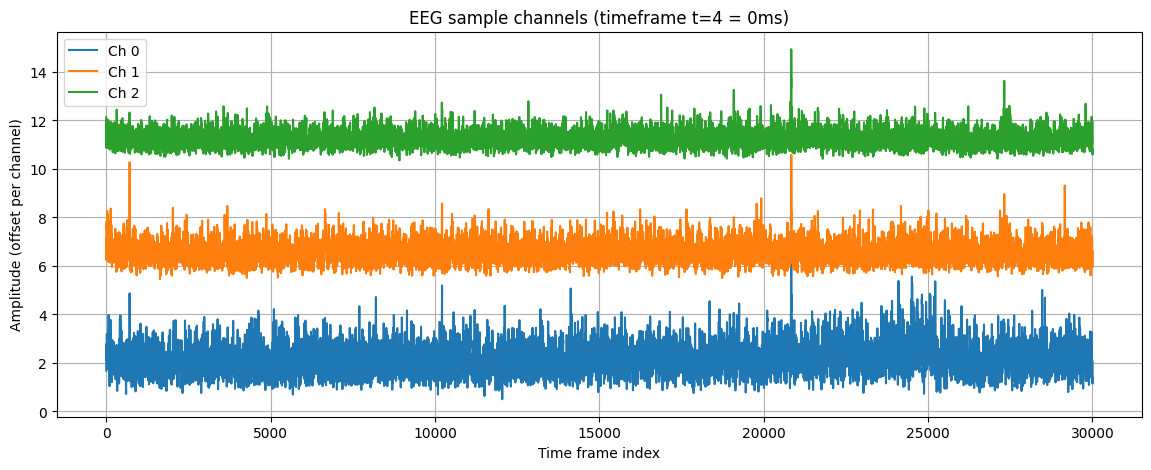

In [ ]:
plt.figure(figsize=(14,5))

for ch in range(3):  # plot first 3 channels from the central timeframe
    plt.plot(EEG_reshaped[:, 4, ch] + ch*5, label=f"Ch {ch}")

plt.title("EEG sample channels (timeframe t=4 = 0ms)")
plt.xlabel("Time frame index")
plt.ylabel("Amplitude (offset per channel)")
plt.legend()
plt.grid(True)
plt.show()


CELL 5 — Visualize Mel Spectrogram

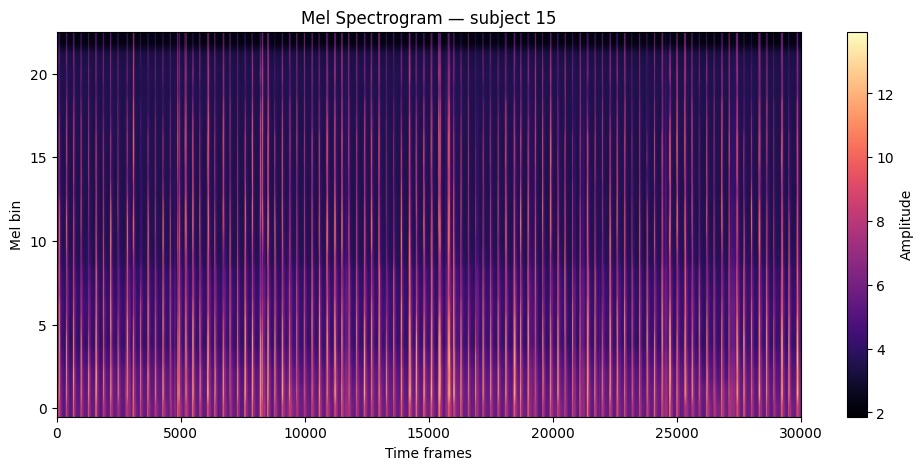

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(MEL.T, aspect='auto', origin='lower', cmap='magma')
plt.title(f"Mel Spectrogram — subject {sub}")
plt.colorbar(label="Amplitude")
plt.xlabel("Time frames")
plt.ylabel("Mel bin")
plt.show()


CELL 6 — Check If All Subjects Have Same Lengths

In [ ]:
lengths_eeg = []
lengths_mel = []

for fname in sorted(os.listdir(ACOUSTIC_PATH)):
    if "_features.npy" in fname:
        subid = fname.split("_")[0]

        eeg = np.load(f"{ACOUSTIC_PATH}/{subid}_features.npy")
        mel = np.load(f"{ACOUSTIC_PATH}/{subid}_spectrogram.npy")

        lengths_eeg.append(eeg.shape[0])
        lengths_mel.append(mel.shape[0])

print("EEG sequence lengths for all subjects :", lengths_eeg)
print("Mel sequence lengths for all subjects :", lengths_mel)

print("\nAre all EEG lengths equal? ", len(set(lengths_eeg)) == 1)
print("Are all Mel lengths equal? ", len(set(lengths_mel)) == 1)


EEG sequence lengths for all subjects : [29985, 29985, 29986, 29986, 29984, 29993, 29991, 29992, 29993, 28460, 29992, 29996, 30017, 30011, 30004]
Mel sequence lengths for all subjects : [29985, 29985, 29986, 29986, 29984, 29993, 29991, 29992, 29993, 28460, 29992, 29996, 30017, 30011, 30004]

Are all EEG lengths equal?  False
Are all Mel lengths equal?  False


CELL 7 — Print Summary

In [ ]:
print("========== SUMMARY ==========")
print(f"EEG sequence length T_eeg   : {T_eeg}")
print(f"Mel sequence length T_mel   : {T_mel}")
print(f"EEG channels (C)            : {C}")
print(f"Mel bins                    : {mel_bins}")
print("EEG temporal shifts         : 9")
print("EEG input per frame         :", flat_dim)
print("=============================")


========== SUMMARY ==========
EEG sequence length T_eeg   : 30004
Mel sequence length T_mel   : 30004
EEG channels (C)            : 65
Mel bins                    : 23
EEG temporal shifts         : 9
EEG input per frame         : 585


Dataset Class (512-frame windowing with overlap)

In [ ]:
# ================================================
#   CELL 3 — Dataset with 512-Frame Windowing
# ================================================

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

WINDOW = 512        # window length
STRIDE = 256        # overlap
EEG_DIM = 585       # flattened 9×65
MEL_DIM = 23        # mel bins


class AcousticDataset(Dataset):
    def __init__(self, eeg, mel, window=WINDOW, stride=STRIDE):
        """
        eeg: (T, 585)
        mel: (T, 23)
        """
        self.eeg = eeg.astype(np.float32)
        self.mel = mel.astype(np.float32)
        self.window = window
        self.stride = stride

        self.samples = []

        T = len(eeg)
        idx = 0

        # Create overlapping windows
        while idx + window <= T:
            self.samples.append(idx)
            idx += stride

        print(f"Dataset created with {len(self.samples)} windows.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        idx = self.samples[i]

        eeg_chunk = self.eeg[idx : idx + self.window]     # (512, 585)
        mel_chunk = self.mel[idx : idx + self.window]     # (512, 23)

        return torch.tensor(eeg_chunk), torch.tensor(mel_chunk)


# Load one subject for now
sub = "15"
EEG = np.load(f"{ACOUSTIC_PATH}/sub-{sub}_features.npy")
MEL = np.load(f"{ACOUSTIC_PATH}/sub-{sub}_spectrogram.npy")

train_ds = AcousticDataset(EEG, MEL)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

print("One batch shapes:")
for eeg_batch, mel_batch in train_loader:
    print("EEG batch:", eeg_batch.shape)   # (B, 512, 585)
    print("Mel batch:", mel_batch.shape)   # (B, 512, 23)
    break


Dataset created with 116 windows.
One batch shapes:
EEG batch: torch.Size([8, 512, 585])
Mel batch: torch.Size([8, 512, 23])


Positional Encoding Module

In [ ]:
# ================================================
#   CELL 4 — Positional Encoding
# ================================================

import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=6000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        """
        x: (B, T, D)
        """
        return x + self.pe[:, :x.size(1), :].to(x.device)


Acoustic Encoder (Transformer)

In [ ]:
# ================================================
#   CELL 5 — Updated EEG Transformer Encoder
# ================================================

class EEGEncoder(nn.Module):
    def __init__(self, input_dim=585, model_dim=256, num_layers=4, num_heads=8):
        super().__init__()

        self.fc_in = nn.Linear(input_dim, model_dim)
        self.pos = PositionalEncoding(model_dim)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=512,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

    def forward(self, x):
        """
        x: (B, T, 585)
        returns: (B, T, 256)
        """
        x = self.fc_in(x)
        x = self.pos(x)
        memory = self.encoder(x)
        return memory


Autoregressive Mel Decoder with Teacher Forcing  :  This predicts mel[t] from mel[t−1] + EEG context.

In [ ]:
# ================================================
#   CELL 6 — Updated Mel Decoder (Cross-Attention)
# ================================================

class Prenet(nn.Module):
    def __init__(self, in_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return x


class MelDecoder(nn.Module):
    def __init__(self, mel_dim=23, model_dim=256, num_layers=4, num_heads=8):
        super().__init__()

        self.prenet = Prenet(mel_dim, model_dim)   # ← NEW PRENET

        self.pos = PositionalEncoding(model_dim)

        dec_layer = nn.TransformerDecoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=512,
            batch_first=True
        )

        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)
        self.out = nn.Linear(model_dim, mel_dim)

    def forward(self, mel_in, memory):
        """
        mel_in: (B, T, 23)
        memory: (B, T, 256)
        """
        tgt = self.prenet(mel_in)   # ← PRENET APPLIED HERE
        tgt = self.pos(tgt)

        out = self.decoder(tgt, memory)
        out = self.out(out)
        return out



Full Acoustic Decoder Model

In [ ]:
class AcousticDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EEGEncoder()
        self.decoder = MelDecoder()
        self.postnet = PostNet()   # ← NEW

    def forward(self, eeg_seq, mel_gt):
        memory = self.encoder(eeg_seq)

        # Teacher-forcing
        mel_in = torch.zeros_like(mel_gt)
        mel_in[:, 1:] = mel_gt[:, :-1]

        mel_pred = self.decoder(mel_in, memory)

        # PostNet refinement (residual)
        mel_post = mel_pred + self.postnet(mel_pred)

        return mel_post


In [ ]:
# ================================================
#   POSTNET (Tacotron-2 style)
# ================================================

class PostNet(nn.Module):
    def __init__(self, mel_dim=23, postnet_dim=512, n_layers=5, kernel_size=5):
        super().__init__()

        layers = []
        for i in range(n_layers):
            in_ch = mel_dim if i == 0 else postnet_dim
            out_ch = mel_dim if i == n_layers - 1 else postnet_dim

            layers.append(
                nn.Sequential(
                    nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size // 2),
                    nn.BatchNorm1d(out_ch),
                    nn.Tanh() if i < n_layers - 1 else nn.Identity(),
                    nn.Dropout(0.5)
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        """
        x: (B, T, mel_dim)
        return: refined mel (B, T, mel_dim)
        """
        x = x.transpose(1, 2)  # (B, mel_dim, T)

        for layer in self.layers:
            x = layer(x)

        x = x.transpose(1, 2)  # back to (B, T, mel_dim)
        return x


training loop with time sampling

In [ ]:
# ================================================
#   CELL 8 — Training Loop for Acoustic Decoder
# ================================================

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = AcousticDecoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 80

def mel_loss(pred, target):
    return F.l1_loss(pred, target)   # L1 = standard mel-spectrogram reconstruction loss


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for eeg_batch, mel_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        eeg_batch = eeg_batch.to(device)
        mel_batch = mel_batch.to(device)

        optimizer.zero_grad()

        mel_pred = model(eeg_batch, mel_batch)

        loss = mel_loss(mel_pred, mel_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Loss: {avg:.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), f"acoustic_decoder_epoch{epoch+1}.pth")
    print(f"Saved checkpoint: acoustic_decoder_epoch{epoch+1}.pth")


Using device: cuda


Epoch 1/80: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]


Epoch 1 — Loss: 3.6678
Saved checkpoint: acoustic_decoder_epoch1.pth


Epoch 2/80: 100%|██████████| 15/15 [00:00<00:00, 15.69it/s]


Epoch 2 — Loss: 2.9153
Saved checkpoint: acoustic_decoder_epoch2.pth


Epoch 3/80: 100%|██████████| 15/15 [00:00<00:00, 15.64it/s]


Epoch 3 — Loss: 2.5208
Saved checkpoint: acoustic_decoder_epoch3.pth


Epoch 4/80: 100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


Epoch 4 — Loss: 2.1276
Saved checkpoint: acoustic_decoder_epoch4.pth


Epoch 5/80: 100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


Epoch 5 — Loss: 1.7938
Saved checkpoint: acoustic_decoder_epoch5.pth


Epoch 6/80: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s]


Epoch 6 — Loss: 1.4584
Saved checkpoint: acoustic_decoder_epoch6.pth


Epoch 7/80: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


Epoch 7 — Loss: 1.1925
Saved checkpoint: acoustic_decoder_epoch7.pth


Epoch 8/80: 100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


Epoch 8 — Loss: 1.0296
Saved checkpoint: acoustic_decoder_epoch8.pth


Epoch 9/80: 100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


Epoch 9 — Loss: 0.9501
Saved checkpoint: acoustic_decoder_epoch9.pth


Epoch 10/80: 100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


Epoch 10 — Loss: 0.9147
Saved checkpoint: acoustic_decoder_epoch10.pth


Epoch 11/80: 100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


Epoch 11 — Loss: 0.8982
Saved checkpoint: acoustic_decoder_epoch11.pth


Epoch 12/80: 100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


Epoch 12 — Loss: 0.8893
Saved checkpoint: acoustic_decoder_epoch12.pth


Epoch 13/80: 100%|██████████| 15/15 [00:00<00:00, 15.56it/s]


Epoch 13 — Loss: 0.8629
Saved checkpoint: acoustic_decoder_epoch13.pth


Epoch 14/80: 100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


Epoch 14 — Loss: 0.8532
Saved checkpoint: acoustic_decoder_epoch14.pth


Epoch 15/80: 100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


Epoch 15 — Loss: 0.8438
Saved checkpoint: acoustic_decoder_epoch15.pth


Epoch 16/80: 100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


Epoch 16 — Loss: 0.8459
Saved checkpoint: acoustic_decoder_epoch16.pth


Epoch 17/80: 100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


Epoch 17 — Loss: 0.8238
Saved checkpoint: acoustic_decoder_epoch17.pth


Epoch 18/80: 100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


Epoch 18 — Loss: 0.8181
Saved checkpoint: acoustic_decoder_epoch18.pth


Epoch 19/80: 100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


Epoch 19 — Loss: 0.8060
Saved checkpoint: acoustic_decoder_epoch19.pth


Epoch 20/80: 100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


Epoch 20 — Loss: 0.8006
Saved checkpoint: acoustic_decoder_epoch20.pth


Epoch 21/80: 100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


Epoch 21 — Loss: 0.7865
Saved checkpoint: acoustic_decoder_epoch21.pth


Epoch 22/80: 100%|██████████| 15/15 [00:00<00:00, 15.51it/s]


Epoch 22 — Loss: 0.7879
Saved checkpoint: acoustic_decoder_epoch22.pth


Epoch 23/80: 100%|██████████| 15/15 [00:00<00:00, 15.39it/s]


Epoch 23 — Loss: 0.7782
Saved checkpoint: acoustic_decoder_epoch23.pth


Epoch 24/80: 100%|██████████| 15/15 [00:00<00:00, 15.40it/s]


Epoch 24 — Loss: 0.7789
Saved checkpoint: acoustic_decoder_epoch24.pth


Epoch 25/80: 100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


Epoch 25 — Loss: 0.7689
Saved checkpoint: acoustic_decoder_epoch25.pth


Epoch 26/80: 100%|██████████| 15/15 [00:00<00:00, 15.34it/s]


Epoch 26 — Loss: 0.7603
Saved checkpoint: acoustic_decoder_epoch26.pth


Epoch 27/80: 100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


Epoch 27 — Loss: 0.7539
Saved checkpoint: acoustic_decoder_epoch27.pth


Epoch 28/80: 100%|██████████| 15/15 [00:00<00:00, 15.32it/s]


Epoch 28 — Loss: 0.7580
Saved checkpoint: acoustic_decoder_epoch28.pth


Epoch 29/80: 100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


Epoch 29 — Loss: 0.7394
Saved checkpoint: acoustic_decoder_epoch29.pth


Epoch 30/80: 100%|██████████| 15/15 [00:00<00:00, 15.28it/s]


Epoch 30 — Loss: 0.7357
Saved checkpoint: acoustic_decoder_epoch30.pth


Epoch 31/80: 100%|██████████| 15/15 [00:00<00:00, 15.28it/s]


Epoch 31 — Loss: 0.7260
Saved checkpoint: acoustic_decoder_epoch31.pth


Epoch 32/80: 100%|██████████| 15/15 [00:00<00:00, 15.23it/s]


Epoch 32 — Loss: 0.7192
Saved checkpoint: acoustic_decoder_epoch32.pth


Epoch 33/80: 100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


Epoch 33 — Loss: 0.7186
Saved checkpoint: acoustic_decoder_epoch33.pth


Epoch 34/80: 100%|██████████| 15/15 [00:00<00:00, 15.09it/s]


Epoch 34 — Loss: 0.7125
Saved checkpoint: acoustic_decoder_epoch34.pth


Epoch 35/80: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Epoch 35 — Loss: 0.7091
Saved checkpoint: acoustic_decoder_epoch35.pth


Epoch 36/80: 100%|██████████| 15/15 [00:00<00:00, 15.22it/s]


Epoch 36 — Loss: 0.7093
Saved checkpoint: acoustic_decoder_epoch36.pth


Epoch 37/80: 100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


Epoch 37 — Loss: 0.7100
Saved checkpoint: acoustic_decoder_epoch37.pth


Epoch 38/80: 100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


Epoch 38 — Loss: 0.7016
Saved checkpoint: acoustic_decoder_epoch38.pth


Epoch 39/80: 100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


Epoch 39 — Loss: 0.6971
Saved checkpoint: acoustic_decoder_epoch39.pth


Epoch 40/80: 100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


Epoch 40 — Loss: 0.7017
Saved checkpoint: acoustic_decoder_epoch40.pth


Epoch 41/80: 100%|██████████| 15/15 [00:00<00:00, 15.02it/s]


Epoch 41 — Loss: 0.6897
Saved checkpoint: acoustic_decoder_epoch41.pth


Epoch 42/80: 100%|██████████| 15/15 [00:01<00:00, 14.99it/s]


Epoch 42 — Loss: 0.6886
Saved checkpoint: acoustic_decoder_epoch42.pth


Epoch 43/80: 100%|██████████| 15/15 [00:00<00:00, 15.02it/s]


Epoch 43 — Loss: 0.6829
Saved checkpoint: acoustic_decoder_epoch43.pth


Epoch 44/80: 100%|██████████| 15/15 [00:00<00:00, 15.09it/s]


Epoch 44 — Loss: 0.6827
Saved checkpoint: acoustic_decoder_epoch44.pth


Epoch 45/80: 100%|██████████| 15/15 [00:01<00:00, 14.99it/s]


Epoch 45 — Loss: 0.6780
Saved checkpoint: acoustic_decoder_epoch45.pth


Epoch 46/80: 100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


Epoch 46 — Loss: 0.6734
Saved checkpoint: acoustic_decoder_epoch46.pth


Epoch 47/80: 100%|██████████| 15/15 [00:00<00:00, 15.05it/s]


Epoch 47 — Loss: 0.6693
Saved checkpoint: acoustic_decoder_epoch47.pth


Epoch 48/80: 100%|██████████| 15/15 [00:00<00:00, 15.04it/s]


Epoch 48 — Loss: 0.6685
Saved checkpoint: acoustic_decoder_epoch48.pth


Epoch 49/80: 100%|██████████| 15/15 [00:00<00:00, 15.15it/s]


Epoch 49 — Loss: 0.6649
Saved checkpoint: acoustic_decoder_epoch49.pth


Epoch 50/80: 100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


Epoch 50 — Loss: 0.6633
Saved checkpoint: acoustic_decoder_epoch50.pth


Epoch 51/80: 100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


Epoch 51 — Loss: 0.6575
Saved checkpoint: acoustic_decoder_epoch51.pth


Epoch 52/80: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Epoch 52 — Loss: 0.6492
Saved checkpoint: acoustic_decoder_epoch52.pth


Epoch 53/80: 100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


Epoch 53 — Loss: 0.6437
Saved checkpoint: acoustic_decoder_epoch53.pth


Epoch 54/80: 100%|██████████| 15/15 [00:00<00:00, 15.05it/s]


Epoch 54 — Loss: 0.6424
Saved checkpoint: acoustic_decoder_epoch54.pth


Epoch 55/80: 100%|██████████| 15/15 [00:00<00:00, 15.05it/s]


Epoch 55 — Loss: 0.6432
Saved checkpoint: acoustic_decoder_epoch55.pth


Epoch 56/80: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Epoch 56 — Loss: 0.6386
Saved checkpoint: acoustic_decoder_epoch56.pth


Epoch 57/80: 100%|██████████| 15/15 [00:00<00:00, 15.11it/s]


Epoch 57 — Loss: 0.6328
Saved checkpoint: acoustic_decoder_epoch57.pth


Epoch 58/80: 100%|██████████| 15/15 [00:00<00:00, 15.08it/s]


Epoch 58 — Loss: 0.6245
Saved checkpoint: acoustic_decoder_epoch58.pth


Epoch 59/80: 100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


Epoch 59 — Loss: 0.6221
Saved checkpoint: acoustic_decoder_epoch59.pth


Epoch 60/80: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Epoch 60 — Loss: 0.6256
Saved checkpoint: acoustic_decoder_epoch60.pth


Epoch 61/80: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Epoch 61 — Loss: 0.6111
Saved checkpoint: acoustic_decoder_epoch61.pth


Epoch 62/80: 100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


Epoch 62 — Loss: 0.6159
Saved checkpoint: acoustic_decoder_epoch62.pth


Epoch 63/80: 100%|██████████| 15/15 [00:00<00:00, 15.11it/s]


Epoch 63 — Loss: 0.6089
Saved checkpoint: acoustic_decoder_epoch63.pth


Epoch 64/80: 100%|██████████| 15/15 [00:00<00:00, 15.16it/s]


Epoch 64 — Loss: 0.6082
Saved checkpoint: acoustic_decoder_epoch64.pth


Epoch 65/80: 100%|██████████| 15/15 [00:00<00:00, 15.18it/s]


Epoch 65 — Loss: 0.6027
Saved checkpoint: acoustic_decoder_epoch65.pth


Epoch 66/80: 100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


Epoch 66 — Loss: 0.5958
Saved checkpoint: acoustic_decoder_epoch66.pth


Epoch 67/80: 100%|██████████| 15/15 [00:00<00:00, 15.19it/s]


Epoch 67 — Loss: 0.5908
Saved checkpoint: acoustic_decoder_epoch67.pth


Epoch 68/80: 100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


Epoch 68 — Loss: 0.5844
Saved checkpoint: acoustic_decoder_epoch68.pth


Epoch 69/80: 100%|██████████| 15/15 [00:00<00:00, 15.15it/s]


Epoch 69 — Loss: 0.5915
Saved checkpoint: acoustic_decoder_epoch69.pth


Epoch 70/80: 100%|██████████| 15/15 [00:00<00:00, 15.18it/s]


Epoch 70 — Loss: 0.5941
Saved checkpoint: acoustic_decoder_epoch70.pth


Epoch 71/80: 100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


Epoch 71 — Loss: 0.5810
Saved checkpoint: acoustic_decoder_epoch71.pth


Epoch 72/80: 100%|██████████| 15/15 [00:00<00:00, 15.22it/s]


Epoch 72 — Loss: 0.5751
Saved checkpoint: acoustic_decoder_epoch72.pth


Epoch 73/80: 100%|██████████| 15/15 [00:00<00:00, 15.17it/s]


Epoch 73 — Loss: 0.5731
Saved checkpoint: acoustic_decoder_epoch73.pth


Epoch 74/80: 100%|██████████| 15/15 [00:00<00:00, 15.19it/s]


Epoch 74 — Loss: 0.5650
Saved checkpoint: acoustic_decoder_epoch74.pth


Epoch 75/80: 100%|██████████| 15/15 [00:00<00:00, 15.21it/s]


Epoch 75 — Loss: 0.5627
Saved checkpoint: acoustic_decoder_epoch75.pth


Epoch 76/80: 100%|██████████| 15/15 [00:00<00:00, 15.24it/s]


Epoch 76 — Loss: 0.5572
Saved checkpoint: acoustic_decoder_epoch76.pth


Epoch 77/80: 100%|██████████| 15/15 [00:00<00:00, 15.29it/s]


Epoch 77 — Loss: 0.5512
Saved checkpoint: acoustic_decoder_epoch77.pth


Epoch 78/80: 100%|██████████| 15/15 [00:00<00:00, 15.29it/s]


Epoch 78 — Loss: 0.5594
Saved checkpoint: acoustic_decoder_epoch78.pth


Epoch 79/80: 100%|██████████| 15/15 [00:00<00:00, 15.27it/s]


Epoch 79 — Loss: 0.5546
Saved checkpoint: acoustic_decoder_epoch79.pth


Epoch 80/80: 100%|██████████| 15/15 [00:00<00:00, 15.27it/s]


Epoch 80 — Loss: 0.5551
Saved checkpoint: acoustic_decoder_epoch80.pth


Autoregressive Inference

In [ ]:
def generate_mel(model, eeg_chunk, steps=512, noise_std=0.012):
    model.eval()

    eeg_chunk = eeg_chunk.to(device)
    memory = model.encoder(eeg_chunk)

    mel_seq = torch.zeros(1, 1, MEL_DIM).to(device)

    for _ in range(steps):

        # Decoder sees full prefix
        out = model.decoder(mel_seq, memory)

        mel_frame = out[:, -1:, :]   # (1,1,23)

        # ==========================
        # ADD GAUSSIAN NOISE HERE
        # ==========================
        noise = torch.randn_like(mel_frame) * noise_std
        mel_frame_noisy = mel_frame + noise
        # ==========================

        mel_seq = torch.cat([mel_seq, mel_frame_noisy], dim=1)

    # Remove initial zero frame
    mel_seq = mel_seq[:, 1:, :]

    # Postnet refinement
    mel_post = mel_seq + model.postnet(mel_seq)

    return mel_post.squeeze(0).detach().cpu().numpy()


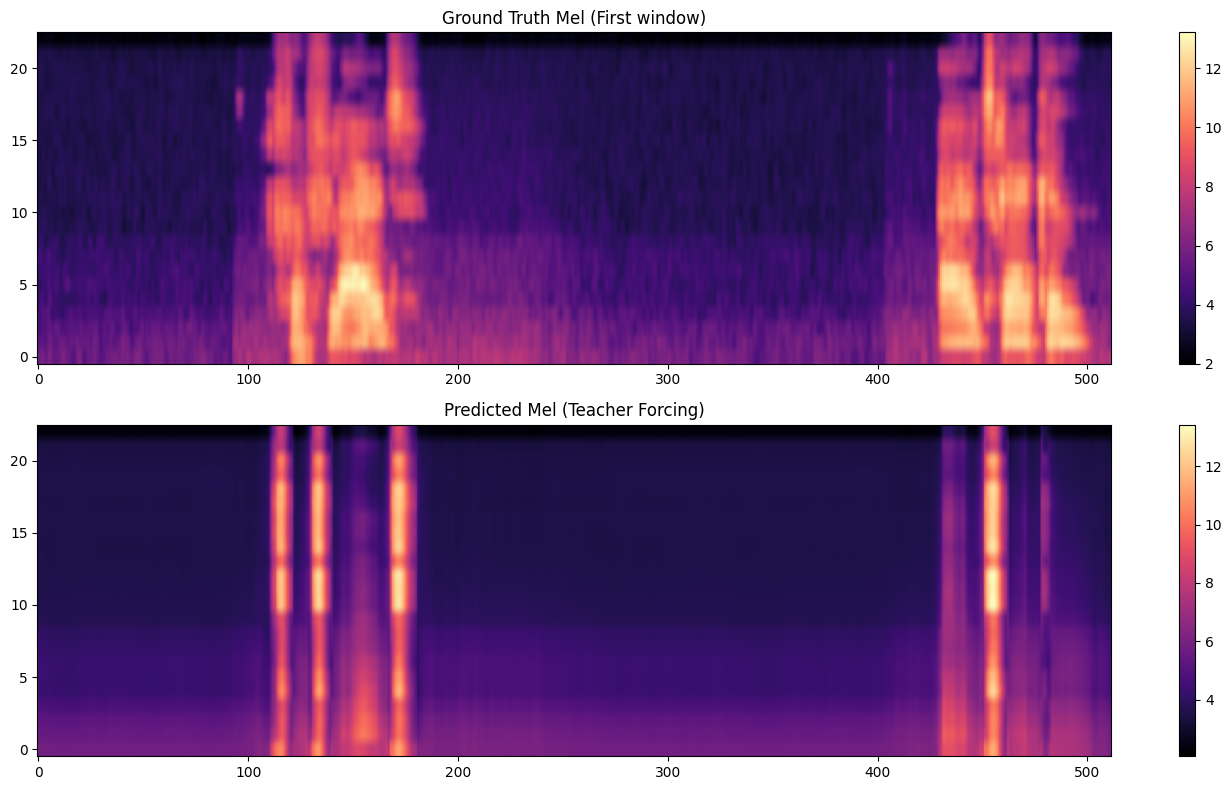

In [ ]:
# ================================================
#   CELL 9 — Mel Comparison (Ground Truth vs Predicted)
# ================================================

import matplotlib.pyplot as plt

model.eval()

# get a batch
eeg_batch, mel_batch = next(iter(train_loader))
eeg_batch = eeg_batch.to(device)
mel_batch = mel_batch.to(device)

# forward pass with teacher forcing
with torch.no_grad():
    mel_pred_tf = model(eeg_batch, mel_batch)   # teacher-forced prediction

# Move to CPU for plotting
mel_gt = mel_batch[0].cpu().numpy()          # (512, 23)
mel_pred_tf_np = mel_pred_tf[0].cpu().numpy()


# =============== PLOT ===============

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title("Ground Truth Mel (First window)")
plt.imshow(mel_gt.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()

plt.subplot(2, 1, 2)
plt.title("Predicted Mel (Teacher Forcing)")
plt.imshow(mel_pred_tf_np.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()


Generated mel shape: (512, 23)


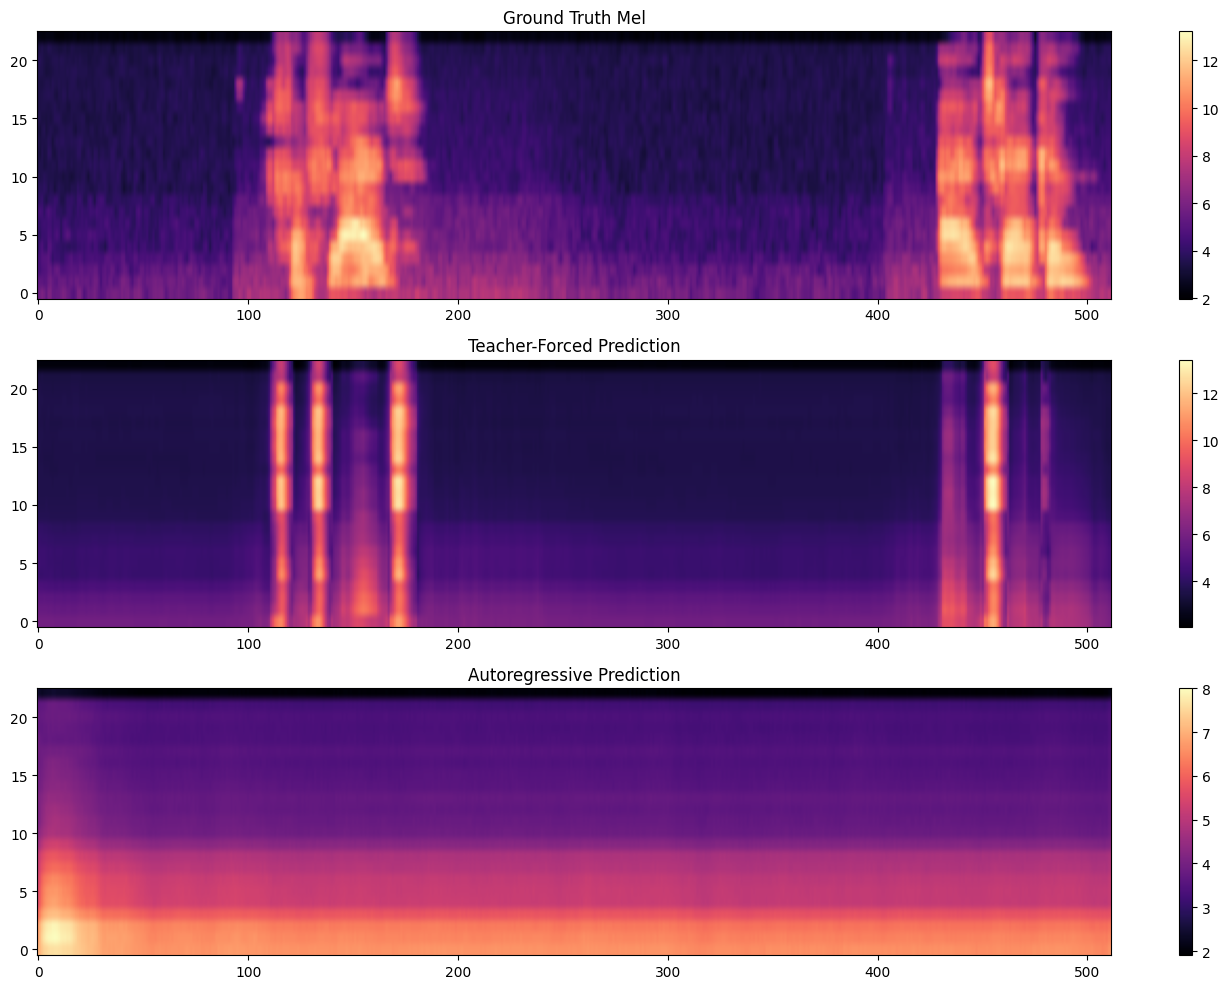

In [ ]:
# ================================================
#   CELL 9B — Autoregressive Inference Comparison
# ================================================

# Take the first EEG chunk
eeg_chunk = eeg_batch[0:1]   # (1, 512, 585)

generated_mel = generate_mel(model, eeg_chunk)
print("Generated mel shape:", generated_mel.shape)

# Plot comparison
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.title("Ground Truth Mel")
plt.imshow(mel_gt.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.title("Teacher-Forced Prediction")
plt.imshow(mel_pred_tf_np.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()

plt.subplot(3, 1, 3)
plt.title("Autoregressive Prediction")
plt.imshow(generated_mel.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# MEL → AUDIO (Griffin-Lim Reconstruction)
# ============================================

import librosa
import librosa.display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

def mel_to_audio(mel, sr=16000, n_fft=1024, hop_length=256, n_mels=23):
    """
    Convert predicted mel spectrogram → audio using Griffin-Lim.
    mel must be shape (T, 23)
    """

    mel = mel.T  # librosa expects (n_mels, T)

    # Use librosa mel basis for inversion
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

    # Pseudo-inverse of mel basis
    inv_mel = np.linalg.pinv(mel_basis)

    # Convert mel → linear spectrogram
    linear_spec = np.maximum(1e-10, np.dot(inv_mel, mel))

    # Convert to audio with Griffin-Lim
    audio = librosa.griffinlim(linear_spec, hop_length=hop_length, n_iter=60)

    return audio


In [ ]:
audio = mel_to_audio(generated_mel)

sf.write("eeg_reconstructed.wav", audio, 16000)

print("Saved: eeg_reconstructed.wav")


Saved: eeg_reconstructed.wav


In [ ]:
from IPython.display import Audio
Audio(audio, rate=16000)


In [ ]:
# ============================================
# Standardize mel variable names for evaluation
# ============================================

# Ground truth mel (512, 23)
mel_gt_np = mel_gt.cpu().numpy() if isinstance(mel_gt, torch.Tensor) else mel_gt

# Teacher-forced predicted mel
mel_pred_tf_np = mel_pred_tf.cpu().numpy() if 'mel_pred_tf' in globals() else None

# Autoregressive predicted mel (what we evaluate)
mel_pred_ar_np = generated_mel  # generated_mel is already a numpy array


In [ ]:
# ============================================
# Evaluation Metrics for Mel Prediction
# ============================================

import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

def evaluate_mel(gt, pred):
    """
    gt, pred: mel spectrograms of shape (T, 23)
    """

    # Flatten for simple metrics
    gt_f = gt.flatten()
    pred_f = pred.flatten()

    mae = np.mean(np.abs(gt_f - pred_f))
    mse = np.mean((gt_f - pred_f)**2)

    # Cosine similarity
    cos_sim = 1 - cosine(gt_f, pred_f)

    # Pearson Correlation
    corr, _ = pearsonr(gt_f, pred_f)

    # Spectral Convergence (common in audio synthesis papers)
    spec_convergence = np.linalg.norm(gt - pred) / np.linalg.norm(gt)

    return {
        "MAE": mae,
        "MSE": mse,
        "Cosine Similarity": cos_sim,
        "Pearson Corr": corr,
        "Spectral Convergence": spec_convergence
    }

# Use your variables from inference
metrics = evaluate_mel(mel_gt_np, mel_pred_ar_np)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


MAE: 1.5178
MSE: 5.8906
Cosine Similarity: 0.9226
Pearson Corr: 0.3614
Spectral Convergence: 0.4146


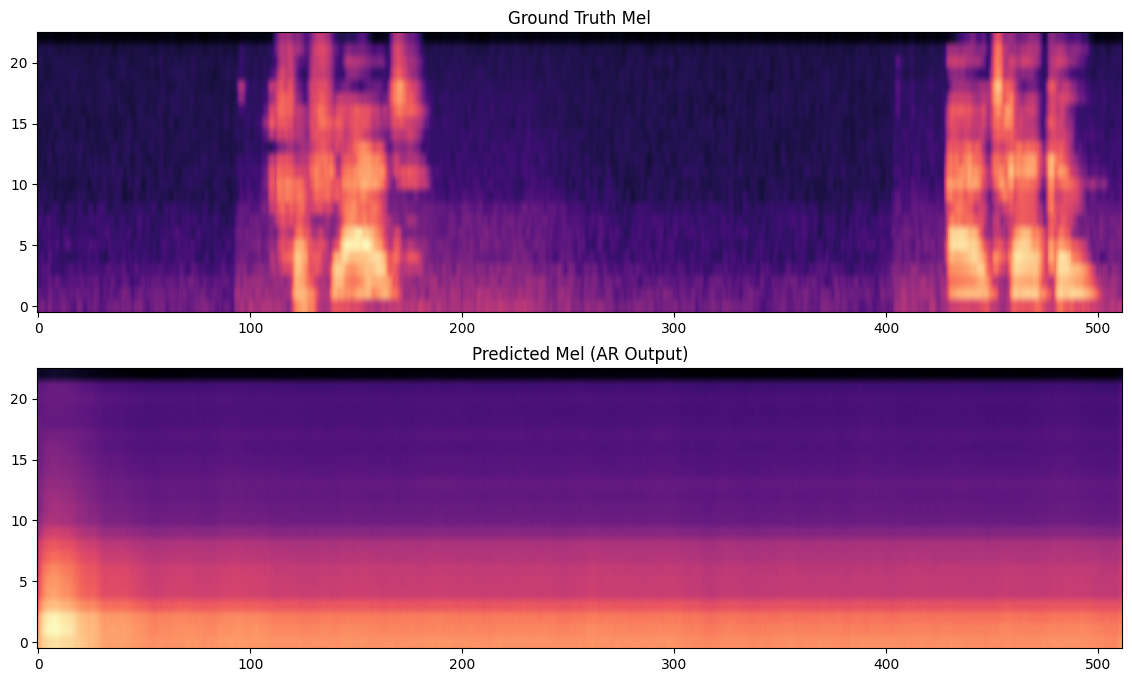

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title("Ground Truth Mel")
plt.imshow(mel_gt_np.T, aspect='auto', origin='lower', cmap='magma')

plt.subplot(2, 1, 2)
plt.title("Predicted Mel (AR Output)")
plt.imshow(mel_pred_ar_np.T, aspect='auto', origin='lower', cmap='magma')

plt.show()


Save Baseline Acoustic Model

In [ ]:
# ============================================
# Save Baseline Acoustic Model (AR Decoder)
# ============================================

import os
import torch

# Define subject ID manually (the one you trained on)
subject = 15   # <-- ADD THIS LINE

save_dir = "/content/drive/MyDrive/EEG_Speech_Dataset/Models"
os.makedirs(save_dir, exist_ok=True)

save_path = f"{save_dir}/acoustic_ar_baseline_sub{subject}.pth"

checkpoint = {
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "subject": subject,
    "epochs": 80,          # or whatever you trained
    "metrics": metrics,    # from evaluation step
    "description": "Autoregressive EEG→Mel acoustic decoder baseline"
}

torch.save(checkpoint, save_path)

print(f"Saved baseline AR model to:\n{save_path}")


Saved baseline AR model to:
/content/drive/MyDrive/EEG_Speech_Dataset/Models/acoustic_ar_baseline_sub15.pth


In [ ]:
# ============================================
# Reload Saved Model (PyTorch 2.6 fix)
# ============================================

checkpoint = torch.load(save_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

print("Model reloaded successfully.")
print("Subject:", checkpoint["subject"])
print("Epochs Trained:", checkpoint["epochs"])
print("Metrics:", checkpoint["metrics"])


Model reloaded successfully.
Subject: 15
Epochs Trained: 80
Metrics: {'MAE': np.float32(1.5177715), 'MSE': np.float32(5.8906384), 'Cosine Similarity': np.float32(0.922596), 'Pearson Corr': np.float32(0.36140156), 'Spectral Convergence': np.float32(0.4145703)}


ALL SUBJECT TRAINING PART STARTS HERE

In [ ]:
# ============================================
# CELL 1 — Load All Subjects Into Memory
# ============================================

import glob

base_path = "/content/drive/MyDrive/EEG_Speech_Dataset/Acoustic"

subjects = {}

for sub_id in range(1, 16):   # subjects 1..15
    feat_path = f"{base_path}/sub-{sub_id:02d}_features.npy"
    mel_path  = f"{base_path}/sub-{sub_id:02d}_spectrogram.npy"

    eeg = np.load(feat_path)
    mel = np.load(mel_path)

    subjects[sub_id] = {
        "eeg": eeg,
        "mel": mel,
        "length": len(eeg)
    }

print("Loaded subjects:", list(subjects.keys()))


Loaded subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
# ============================================
# CELL 2 — Multi-Subject Dataset (updated)
# ============================================

class MultiSubjectDatasetFromList(Dataset):
    def __init__(self, subjects_dict, sample_list, window=512):
        self.subjects = subjects_dict
        self.samples = sample_list
        self.window = window

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sub_id, start = self.samples[idx]
        end = start + self.window

        eeg = self.subjects[sub_id]["eeg"][start:end]
        mel = self.subjects[sub_id]["mel"][start:end]

        return (
            torch.tensor(eeg, dtype=torch.float32),
            torch.tensor(mel, dtype=torch.float32),
            sub_id
        )


In [ ]:
# ============================================
# Flexible Subject-Specific Projectors
# ============================================

class SubjectProjectors(nn.Module):
    def __init__(self, subjects_dict, out_dim=256):
        super().__init__()

        self.projectors = nn.ModuleDict()

        for sub_id, data in subjects_dict.items():
            in_dim = data["eeg"].shape[1]   # auto-detect feature dimension
            self.projectors[str(sub_id)] = nn.Linear(in_dim, out_dim)

    def forward(self, x, sub_id):
        return self.projectors[str(sub_id)](x)


In [ ]:
# ============================================
# CELL 4 — Encoder With Projector Support
# ============================================

class EEGEncoder(nn.Module):
    def __init__(self, projectors, model_dim=256, layers=4, heads=8):
        super().__init__()
        self.projectors = projectors
        self.pos = PositionalEncoding(model_dim)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=heads,
            dim_feedforward=512,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, layers)

    def forward(self, x, sub_id):
        x = self.projectors(x, sub_id)
        x = self.pos(x)
        return self.encoder(x)


In [ ]:
# ============================================
# Correct Multi-Subject Acoustic Decoder
# ============================================

class MultiSubjectAcousticDecoder(nn.Module):
    def __init__(self, projectors):
        super().__init__()

        self.projectors = projectors                     # <-- use external projector
        self.encoder = EEGEncoder(self.projectors)       # <-- pass it into encoder
        self.decoder = MelDecoder()                      # your AR decoder
        self.postnet = PostNet()                         # refinement

    def forward(self, eeg_seq, mel_in, sub_id):
        memory = self.encoder(eeg_seq, sub_id)
        mel_pred = self.decoder(mel_in, memory)
        mel_post = mel_pred + self.postnet(mel_pred)
        return mel_post


In [ ]:
# ============================================
# Check EEG feature dimensions per subject
# ============================================

for sub_id, data in subjects.items():
    print(f"Subject {sub_id:02d}: EEG feature dim = {data['eeg'].shape[1]}")


Subject 01: EEG feature dim = 1143
Subject 02: EEG feature dim = 1143
Subject 03: EEG feature dim = 1143
Subject 04: EEG feature dim = 1035
Subject 05: EEG feature dim = 540
Subject 06: EEG feature dim = 1143
Subject 07: EEG feature dim = 1143
Subject 08: EEG feature dim = 486
Subject 09: EEG feature dim = 1053
Subject 10: EEG feature dim = 1098
Subject 11: EEG feature dim = 612
Subject 12: EEG feature dim = 1143
Subject 13: EEG feature dim = 1413
Subject 14: EEG feature dim = 1143
Subject 15: EEG feature dim = 585


In [ ]:
# ============================================
# Pad all EEG features to the max dimension
# ============================================

max_dim = max(data["eeg"].shape[1] for data in subjects.values())
print("Max EEG feature dimension:", max_dim)

for sub_id, data in subjects.items():
    eeg = data["eeg"]
    dim = eeg.shape[1]

    if dim < max_dim:
        pad_width = max_dim - dim
        pad = np.zeros((eeg.shape[0], pad_width))
        eeg_padded = np.concatenate([eeg, pad], axis=1)
        subjects[sub_id]["eeg"] = eeg_padded
    else:
        subjects[sub_id]["eeg"] = eeg

print("All EEG features now padded to:", max_dim)


Max EEG feature dimension: 1413
All EEG features now padded to: 1413


In [ ]:
projectors = nn.ModuleDict({
    str(sub_id): nn.Linear(max_dim, 256)
    for sub_id in subjects.keys()
}).to(device)


In [ ]:
# ============================================
# Subject-specific projectors (1413 → 256)
# ============================================

max_dim = 1413   # confirmed earlier

projectors = nn.ModuleDict({
    str(sub_id): nn.Linear(max_dim, 256)
    for sub_id in subjects.keys()
}).to(device)

print("Built projectors for subjects:", list(projectors.keys()))


Built projectors for subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']


In [ ]:
class EEGEncoder(nn.Module):
    def __init__(self, projectors, model_dim=256, layers=4, heads=8):
        super().__init__()
        self.projectors = projectors
        self.pos = PositionalEncoding(model_dim)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=heads,
            dim_feedforward=512,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, layers)

    def forward(self, x, sub_id):
        # x shape: (B, T, 1413)
        x = self.projectors[str(sub_id)](x)   # (B, T, 256)
        x = self.pos(x)
        return self.encoder(x)


In [ ]:
class MultiSubjectAcousticDecoder(nn.Module):
    def __init__(self, projectors):
        super().__init__()

        self.projectors = projectors
        self.encoder = EEGEncoder(self.projectors)
        self.decoder = MelDecoder()      # your AR decoder
        self.postnet = PostNet()         # refinement

    def forward(self, eeg_seq, mel_in, sub_id):
        memory = self.encoder(eeg_seq, sub_id)
        mel_pred = self.decoder(mel_in, memory)
        mel_post = mel_pred + self.postnet(mel_pred)
        return mel_post


In [ ]:
# ============================================
# Build full multisubject model
# ============================================

model = MultiSubjectAcousticDecoder(projectors).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Multi-subject model ready.")


Multi-subject model ready.


In [ ]:
dataset = MultiSubjectDataset(subjects, window=512)

loader = DataLoader(
    dataset,
    batch_size=1,       # now batching works!
    shuffle=True,
    drop_last=True
)

print("Total windows:", len(dataset))


In [ ]:
# ============================================
# RESET MODEL + OPTIMIZER COMPLETELY
# ============================================

torch.cuda.empty_cache()
import gc
gc.collect()

projectors = nn.ModuleDict({
    str(sub_id): nn.Linear(max_dim, 256)
    for sub_id in subjects.keys()
}).to(device)

model = MultiSubjectAcousticDecoder(projectors).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model + optimizer reset for clean training.")


In [ ]:
def train_multisubject(model, loader, optimizer, epochs=40):
    criterion = nn.L1Loss()

    for epoch in range(1, epochs + 1):
        total_loss = 0
        model.train()

        for eeg_seq, mel_gt, sub_id in loader:
            eeg_seq = eeg_seq.to(device)
            mel_gt = mel_gt.to(device)

            # Convert tensor → Python int
            sub_id = int(sub_id)

            # Teacher forcing
            mel_in = torch.zeros_like(mel_gt)
            mel_in[:, 1:] = mel_gt[:, :-1]

            mel_pred = model(eeg_seq, mel_in, sub_id)

            loss = criterion(mel_pred, mel_gt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} — Loss: {total_loss:.4f}")


In [ ]:
def train_multisubject(model, loader, optimizer, epochs=40):
    criterion = nn.L1Loss()

    # Older PyTorch versions: no 'verbose' argument
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3
    )

    for epoch in range(1, epochs + 1):

        total_loss = 0.0
        model.train()

        for eeg_seq, mel_gt, sub_id in loader:
            eeg_seq = eeg_seq.to(device)
            mel_gt = mel_gt.to(device)
            sub_id = int(sub_id)

            # Teacher forcing
            mel_in = torch.zeros_like(mel_gt)
            mel_in[:, 1:] = mel_gt[:, :-1]

            mel_pred = model(eeg_seq, mel_in, sub_id)
            loss = criterion(mel_pred, mel_gt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} — Loss: {total_loss:.4f}")

        # Scheduler step
        scheduler.step(total_loss)


In [ ]:
train_multisubject(model, loader, optimizer, epochs=10)


In [ ]:
def train_curriculum(model, subjects, window=512, epochs_per_subject=1, cycles=3):

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2   # more responsive for curriculum
    )

    for cycle in range(cycles):
        print("\n====================================")
        print(f"   CURRICULUM CYCLE {cycle+1}/{cycles}")
        print("====================================")

        for sub_id in subjects.keys():
            print(f"\nTraining Subject {sub_id}...")

            ds = MultiSubjectDataset({sub_id: subjects[sub_id]}, window=window)
            dl = DataLoader(ds, batch_size=1, shuffle=True)

            for epoch in range(epochs_per_subject):
                total_loss = 0
                model.train()

                for eeg_seq, mel_gt, sid in dl:
                    sid = int(sid)
                    eeg_seq = eeg_seq.to(device)
                    mel_gt = mel_gt.to(device)

                    mel_in = torch.zeros_like(mel_gt)
                    mel_in[:, 1:] = mel_gt[:, :-1]

                    pred = model(eeg_seq, mel_in, sid)
                    loss = criterion(pred, mel_gt)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                print(f"  Subject {sub_id} — Epoch {epoch+1}/{epochs_per_subject} — Loss: {total_loss:.4f}")

            # 🔥 Step LR scheduler once per subject phase
            scheduler.step(total_loss)


In [ ]:
train_curriculum(model, subjects, epochs_per_subject=1, cycles=3)


In [ ]:
def generate_mel_multisubject(model, eeg_chunk, sub_id, steps=512, noise_std=0.012):
    """
    Autoregressive mel-spectrogram generation for the multi-subject model.
    Requires sub_id because encoder projection is subject-specific.
    """
    model.eval()
    eeg_chunk = eeg_chunk.to(device)

    # Encode EEG with subject-specific projector
    with torch.no_grad():
        memory = model.encoder(eeg_chunk, sub_id)

    # Initial mel zero-frame
    mel_seq = torch.zeros(1, 1, MEL_DIM).to(device)

    for _ in range(steps):
        # Decoder attends to the full prefix
        out = model.decoder(mel_seq, memory)
        mel_frame = out[:, -1:, :]

        # Add stabilizing Gaussian noise
        mel_frame = mel_frame + torch.randn_like(mel_frame) * noise_std

        mel_seq = torch.cat([mel_seq, mel_frame], dim=1)

    mel_seq = mel_seq[:, 1:, :]

    # Post-net refinement (exactly like your baseline)
    if hasattr(model, "postnet"):
        mel_seq = mel_seq + model.postnet(mel_seq)

    return mel_seq.squeeze(0).detach().cpu().numpy()


In [ ]:
# ============================================
# Evaluation block (corrected for multisubject)
# ============================================

sub_id = 1

# take first 512-frame window from this subject
ds = MultiSubjectDataset({sub_id: subjects[sub_id]}, window=512)
eeg_seq, mel_gt, _ = ds[0]

eeg_seq = eeg_seq.unsqueeze(0).to(device)
mel_gt  = mel_gt.unsqueeze(0).to(device)

# -------- Teacher-forced prediction --------
mel_in = torch.zeros_like(mel_gt)
mel_in[:, 1:] = mel_gt[:, :-1]

model.eval()
with torch.no_grad():
    mel_pred_tf = model(eeg_seq, mel_in, sub_id).cpu().numpy()

# -------- Autoregressive prediction (correct function) --------
mel_pred_ar = generate_mel_multisubject(model, eeg_seq, sub_id)

# -------- Convert to numpy --------
mel_gt_np = mel_gt.squeeze(0).cpu().numpy()
mel_tf_np = mel_pred_tf.squeeze(0)
mel_ar_np = mel_pred_ar


In [ ]:
# take one subject for evaluation
sub_id = 1
ds = MultiSubjectDataset({sub_id: subjects[sub_id]}, window=512)
eeg_seq, mel_gt, _ = ds[0]

eeg_seq = eeg_seq.unsqueeze(0).to(device)
mel_gt = mel_gt.unsqueeze(0).to(device)

mel_in = torch.zeros_like(mel_gt)
mel_in[:, 1:] = mel_gt[:, :-1]

model.eval()
with torch.no_grad():
    mel_pred_tf = model(eeg_seq, mel_in, sub_id).cpu().numpy()

# autoregressive prediction
mel_pred_ar = generate_mel(model, eeg_seq)

# detach and reshape
mel_gt_np = mel_gt.squeeze(0).cpu().numpy()
mel_tf_np = mel_pred_tf.squeeze(0)
mel_ar_np = mel_pred_ar


In [ ]:
# ============================================
# SIMPLE MULTISUBJECT EVALUATION (NO AR NEEDED)
# ============================================

sub_id = 1   # pick any subject
ds = MultiSubjectDataset({sub_id: subjects[sub_id]}, window=512)

# get first window
eeg_seq, mel_gt, _ = ds[0]

eeg_seq = eeg_seq.unsqueeze(0).to(device)
mel_gt = mel_gt.unsqueeze(0).to(device)

# Teacher forcing input
mel_in = torch.zeros_like(mel_gt)
mel_in[:, 1:] = mel_gt[:, :-1]

# Predict
model.eval()
with torch.no_grad():
    mel_pred = model(eeg_seq, mel_in, sub_id).cpu().numpy()

# Remove batch dimension
mel_gt_np = mel_gt.squeeze(0).cpu().numpy()
mel_pred_np = mel_pred.squeeze(0)


# --------- Metrics ----------

gt_f = mel_gt_np.flatten()
pr_f = mel_pred_np.flatten()

mae = np.mean(np.abs(gt_f - pr_f))
mse = np.mean((gt_f - pr_f)**2)
cos_sim = 1 - cosine(gt_f, pr_f)
corr, _ = pearsonr(gt_f, pr_f)
spec_conv = np.linalg.norm(mel_gt_np - mel_pred_np) / np.linalg.norm(mel_gt_np)

print("MAE:", mae)
print("MSE:", mse)
print("Cosine similarity:", cos_sim)
print("Pearson correlation:", corr)
print("Spectral convergence:", spec_conv)


In [ ]:
# ================================
# INSPECT ACOUSTIC CHECKPOINT
# ================================

import torch, os

# Try to automatically detect saved .pt or .pth files
acoustic_files = [f for f in os.listdir() if f.endswith((".pt", ".pth"))]
print("Detected acoustic checkpoint files:", acoustic_files)

# If multiple files appear, pick the correct one manually
if len(acoustic_files) == 1:
    path = acoustic_files[0]
    print("\nLoading:", path)
    ckpt = torch.load(path, map_location="cpu")
    print("Checkpoint keys:", ckpt.keys())
else:
    print("\nPlease tell me which file is the correct checkpoint.")


Detected acoustic checkpoint files: ['acoustic_decoder_epoch26.pth', 'acoustic_decoder_epoch5.pth', 'acoustic_decoder_epoch74.pth', 'acoustic_decoder_epoch77.pth', 'acoustic_decoder_epoch42.pth', 'acoustic_decoder_epoch67.pth', 'acoustic_decoder_epoch44.pth', 'acoustic_decoder_epoch12.pth', 'acoustic_decoder_epoch54.pth', 'acoustic_decoder_epoch30.pth', 'acoustic_decoder_epoch19.pth', 'acoustic_decoder_epoch70.pth', 'acoustic_decoder_epoch65.pth', 'acoustic_decoder_epoch64.pth', 'acoustic_decoder_epoch62.pth', 'acoustic_decoder_epoch71.pth', 'acoustic_decoder_epoch51.pth', 'acoustic_decoder_epoch53.pth', 'acoustic_decoder_epoch39.pth', 'acoustic_decoder_epoch45.pth', 'acoustic_decoder_epoch20.pth', 'acoustic_decoder_epoch46.pth', 'acoustic_decoder_epoch50.pth', 'acoustic_decoder_epoch33.pth', 'acoustic_decoder_epoch9.pth', 'acoustic_decoder_epoch4.pth', 'acoustic_decoder_epoch13.pth', 'acoustic_decoder_epoch1.pth', 'acoustic_decoder_epoch18.pth', 'acoustic_decoder_epoch7.pth', 'acousti

In [ ]:
ckpt = torch.load("acoustic_decoder_epoch80.pth", map_location="cpu")
print(ckpt.keys())


odict_keys(['encoder.fc_in.weight', 'encoder.fc_in.bias', 'encoder.encoder.layers.0.self_attn.in_proj_weight', 'encoder.encoder.layers.0.self_attn.in_proj_bias', 'encoder.encoder.layers.0.self_attn.out_proj.weight', 'encoder.encoder.layers.0.self_attn.out_proj.bias', 'encoder.encoder.layers.0.linear1.weight', 'encoder.encoder.layers.0.linear1.bias', 'encoder.encoder.layers.0.linear2.weight', 'encoder.encoder.layers.0.linear2.bias', 'encoder.encoder.layers.0.norm1.weight', 'encoder.encoder.layers.0.norm1.bias', 'encoder.encoder.layers.0.norm2.weight', 'encoder.encoder.layers.0.norm2.bias', 'encoder.encoder.layers.1.self_attn.in_proj_weight', 'encoder.encoder.layers.1.self_attn.in_proj_bias', 'encoder.encoder.layers.1.self_attn.out_proj.weight', 'encoder.encoder.layers.1.self_attn.out_proj.bias', 'encoder.encoder.layers.1.linear1.weight', 'encoder.encoder.layers.1.linear1.bias', 'encoder.encoder.layers.1.linear2.weight', 'encoder.encoder.layers.1.linear2.bias', 'encoder.encoder.layers.1.